# Importing packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# The dataset we will be working with consists of 16 folders each containing 8 separate .csv files. 
# The data is available at
# https://physionet.org/content/big-ideas-glycemic-wearable/1.1.2/
# In order to work with the data, we define some helper functions

# Import helper functions:
from data_processing.cgm_data import CGMData
from data_processing.cgm_data_helper import plot_series_with_food, plot_series_with_diff
from data_processing.derived_datasets import max_glucose_dataset,max_glucose_between_meals_dataset

TO DO: Say more about what these helper functions do? The raw data looks different than the data imported by these functions... 

In [3]:
data = CGMData()

In [4]:
# Verify all datasets load properly
pat_num = 2
for i in range(pat_num,pat_num+1):
  for data_str in ['acc', 'bvp', 'glu', 'eda', 'food', 'hr', 'ibi', 'temp']:
    print(i, data_str)
    try:
      print(data[i].__getattribute__(data_str).head(3))
    except Exception as e:
      print(f"Error on patient {i} with {data_str}: {e}")

2 acc
                               acc_x     acc_y     acc_z
datetime                                                
2020-02-21 09:19:06.000000 -1.544882 -5.407087  8.033386
2020-02-21 09:19:06.031250 -1.544882 -5.407087  7.878898
2020-02-21 09:19:06.062500 -1.544882 -5.407087  7.878898
2 bvp
                            bvp
datetime                       
2020-02-21 09:19:06.000000 -0.0
2020-02-21 09:19:06.015625 -0.0
2020-02-21 09:19:06.031250 -0.0
2 glu
                     glucose
datetime                    
2020-02-21 11:08:36    186.0
2020-02-21 11:13:36    181.0
2020-02-21 11:18:36    175.0
2 eda
                              eda
datetime                         
2020-02-21 09:19:06.000  0.000000
2020-02-21 09:19:06.250  0.139648
2020-02-21 09:19:06.500  0.202426
2 food
                    time_end                   logged_food  amount  \
time_begin                                                           
2020-02-21 10:09:00      NaT                   Mello Yello    12.0   

# Demographics

In [5]:
# The demographic data available gives gender at HbA1C values for each of the patients
# For instance, patient 1's demographics are
print(data[1].gender)
print(data[1].hba1c)


FEMALE
5.5


In [6]:
# Visualizing the demographics across 16 patients
Gender_counts = data.demographics['Gender'].value_counts().sort_index()
HbA1c_counts = data.demographics['HbA1c'].value_counts().sort_index()

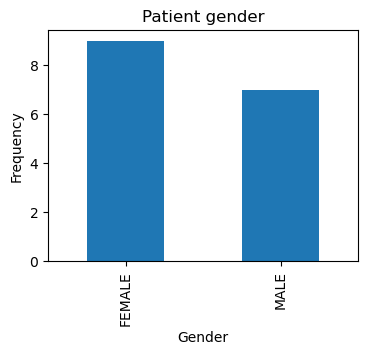

In [7]:
# Gender bar graph
plt.figure(figsize=(4, 3))
Gender_counts.plot(kind='bar')

plt.title('Patient gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')

plt.show()

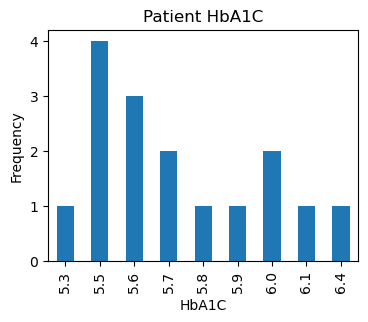

In [8]:
# HbA1C bar graph
plt.figure(figsize=(4, 3))
HbA1c_counts.plot(kind='bar')

plt.title('Patient HbA1C')
plt.xlabel('HbA1C')
plt.ylabel('Frequency')

plt.show()

Hemoglobin A1C (HbA1C) is a measure of the general level of bloodsugar over the previous few months. HbA1C levels correlate with diabetes in the following manner (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4933534/):
* A nondiabetic patient usually falls within the 4.0%–5.6% HbA1C range. 
* A prediabetic patient usually has the HbA1C levels as 5.7%–6.4%.
* A patient with 6.4% or higher HbA1C levels has diabetes. 

The BIG IDEAs Lab Glycemic Variability and Wearable Device Data dataset was collected as part of a study "to determine the feasibility and effectiveness of wearable devices in detecting early physiological changes prior to the development of prediabetes." (https://physionet.org/content/big-ideas-glycemic-wearable/1.1.2/) Hence, the HbA1C range of patients spans from "high normal" to "prediabetes". These are patients who are not taking insulin externally, but whose bodies are not regulating bloodsugar levels as well as normal.

TO DO: find any gaps in the glucose data? I.e., if there are time periods in which we do not have 5-minute frequency of data collection.

# Observing a relationship between food intake and glucose level

In [9]:
# Patient data is taken over different time periods. 
print('Patient 1 has glucose data starting at')
print(data[1].glu.index.min())
print('and ending at')
print(data[1].glu.index.max())

print()

print('Patient 2 has glucose data starting at')
print(data[2].glu.index.min())
print('and ending at')
print(data[2].glu.index.max())

Patient 1 has glucose data starting at
2020-02-13 17:23:32
and ending at
2020-02-22 17:53:23

Patient 2 has glucose data starting at
2020-02-21 11:08:36
and ending at
2020-02-29 09:38:24


In [10]:
# Patient 1's food log:
data[1].food.head()

,time_end,logged_food,amount,unit,searched_food,calorie,total_carb,dietary_fiber,sugar,protein,total_fat
time_begin,,,,,,,,,,,
2020-02-13 18:00:00,NaT,Berry Smoothie,20.00,fluid ounce,Strawberry Smoothie,456.0,85.0,1.7,83.0,16.0,3.3
2020-02-13 20:30:00,NaT,Chicken Leg,1.00,NaN,chicken leg,475.0,0.0,0.0,0.0,62.0,23.0
2020-02-13 20:30:00,NaT,Asparagus,4.00,NaN,Asparagus,13.0,2.5,1.2,0.8,1.4,0.1
2020-02-14 07:10:00,NaT,Natrel Lactose Free 2 Percent,8.00,fluid ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,120.0,9.0,NaN,8.0,12.0,NaN
2020-02-14 07:10:00,NaT,Standard Breakfast,0.75,cup,"(Kellogg's) Frosted Flakes, Cereal",110.0,26.0,NaN,10.0,1.0,NaN


Patient 1 HbA1C: 5.5
Data avaliable from 2020-02-13 17:23:32 to 2020-02-22 17:53:23


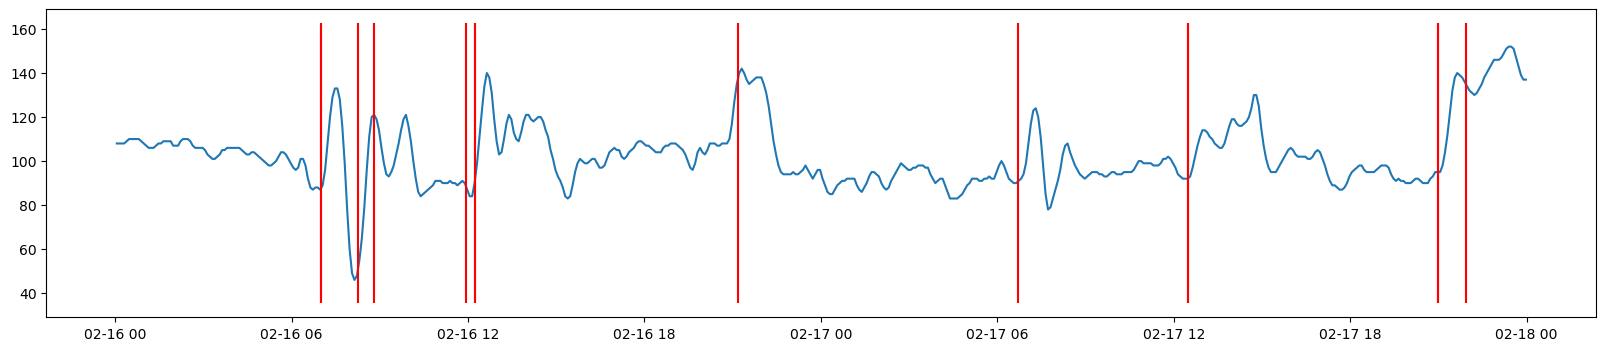

In [11]:
# Patient 1's glucose data with red lines indicating time of logged food intake
print('Patient 1 HbA1C:', data[1].hba1c)
print('Data avaliable from',data[1].glu.index.min(),'to',data[1].glu.index.max())
plot_series_with_food(data[1].glu, data[1].food, '2020-02-16', '2020-02-17')

Note that glucose generally spikes after food intake. For a person with diabetes, hyperglycemia (high blood sugar level) is usually considered to be greater than 180 mg/dL one to two hours after eating (https://my.clevelandclinic.org/health/diseases/9815-hyperglycemia-high-blood-sugar). The patient above has a 5.5 HbA1C, which is in the high-but-normal (nondiabetic) range, and we see spikes reaching 120-140 (sometimes even less).

For comparison, here is similar data for another patient:

Patient 2 HbA1C: 5.6
Data available from 2020-02-21 11:08:36 to 2020-02-29 09:38:24


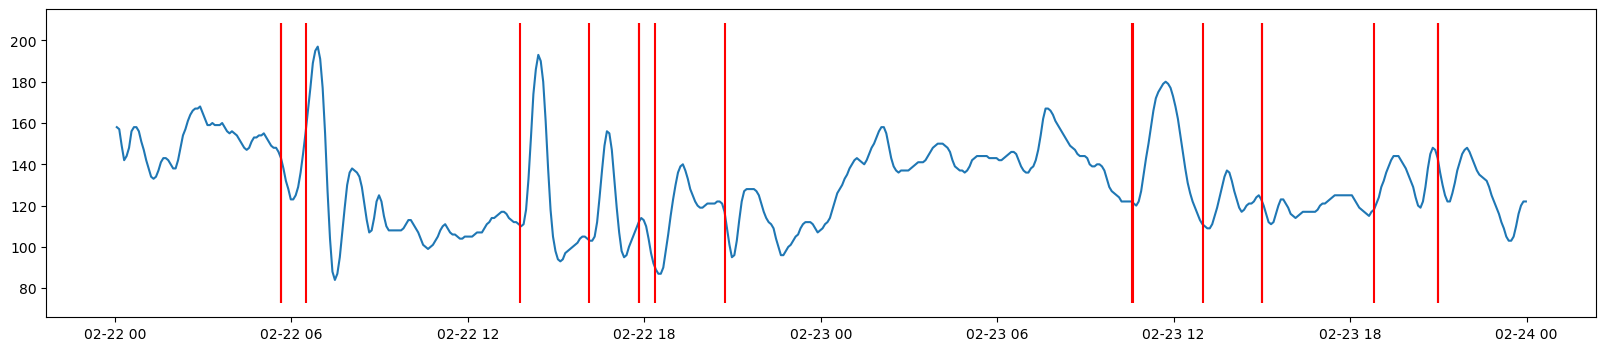

In [12]:
# Patient 2's glucose data with red lines indicating time of logged food intake
print('Patient 2 HbA1C:', data[2].hba1c)
print('Data available from',data[2].glu.index.min(),'to',data[2].glu.index.max())
plot_series_with_food(data[2].glu, data[2].food, '2020-02-22', '2020-02-23')

We would like to predict features of the glucose spike after a meal.

A basic version of this problem is a classification problem: which meals lead to a high bloodsugar event? To pursue this, we look at our available data for quantifying a meal as well as how to determine what counts as a high bloodsugar event.

## High bloodsugar events

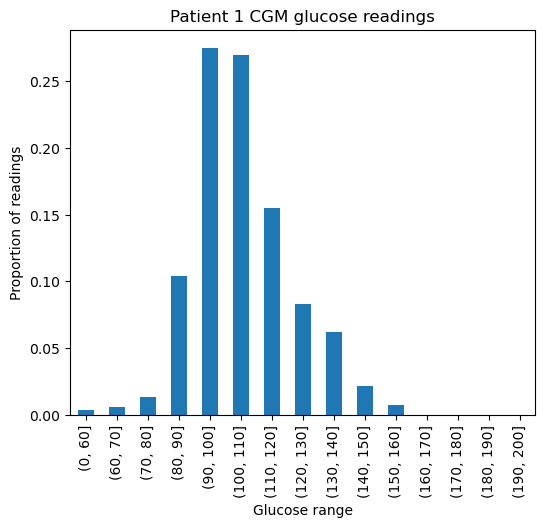

In [13]:
# Histogram of glucose readings for Patient 1
bins = pd.IntervalIndex.from_tuples([(0,60),(60,70),(70,80),(80,90),(90,100),(100,110),(110,120),(120,130),(130,140),(140,150),(150,160),(160,170),(170,180),(180,190),(190,200)])
pd.cut(data[1].glu['glucose'],bins).value_counts(normalize=True).sort_index().plot.bar(figsize=(6,5))
plt.title('Patient 1 CGM glucose readings')
plt.xlabel("Glucose range");
plt.ylabel("Proportion of readings");

plt.show()

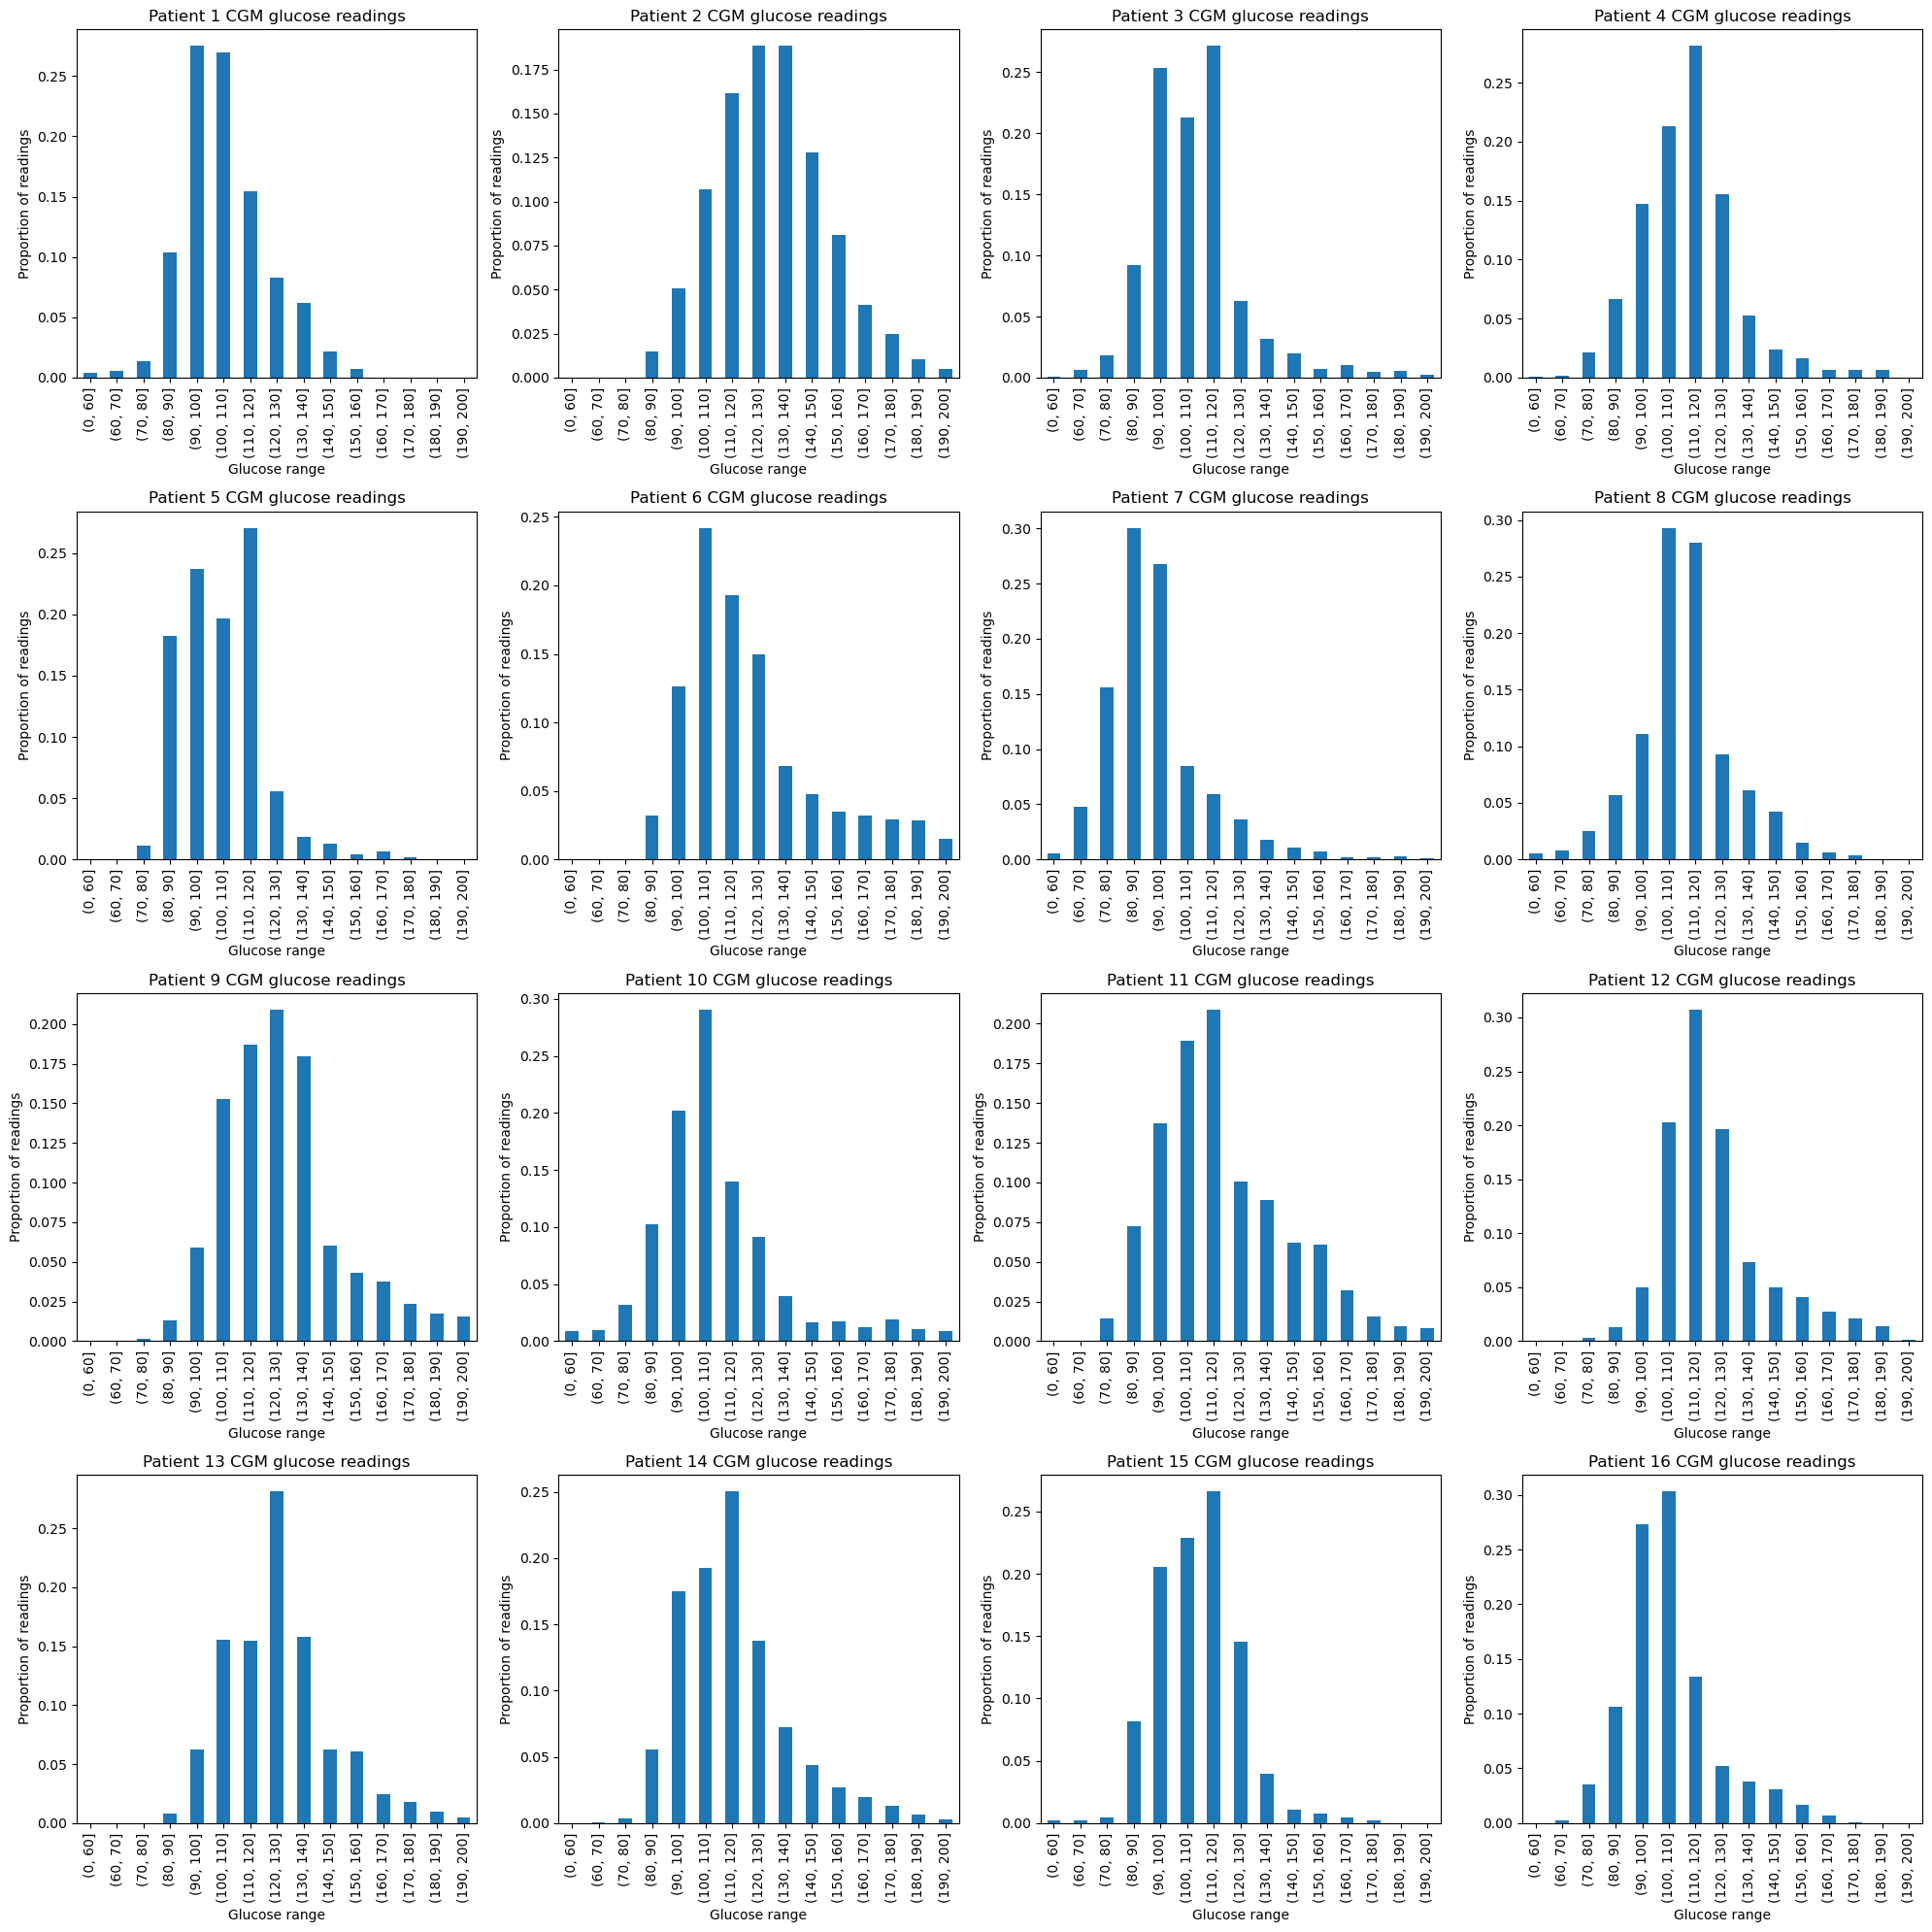

In [14]:
# Histograms for all 16 patients

# Create a figure with a 4x4 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.flatten()

# Loop through each patient and create a histogram in the respective subplot
for i in range(1, 17):
    ax = axes[i-1]
    patient_data = data[i].glu['glucose']
    pd.cut(patient_data, bins).value_counts(normalize=True).sort_index().plot.bar(ax=ax)
    ax.set_title(f'Patient {i} CGM glucose readings')
    ax.set_xlabel("Glucose range")
    ax.set_ylabel("Proportion of readings")

plt.tight_layout()
plt.show()

### Version 1: high bloodsugar set at a fixed level determined by each patient's bloodsugar data

Some patients have generally higher/lower bloodsugars than others, so what counts as a high bloodsugar should be patient-specific.

High bloodsugar for Patient 1 set at 137.0 (95th percentile)


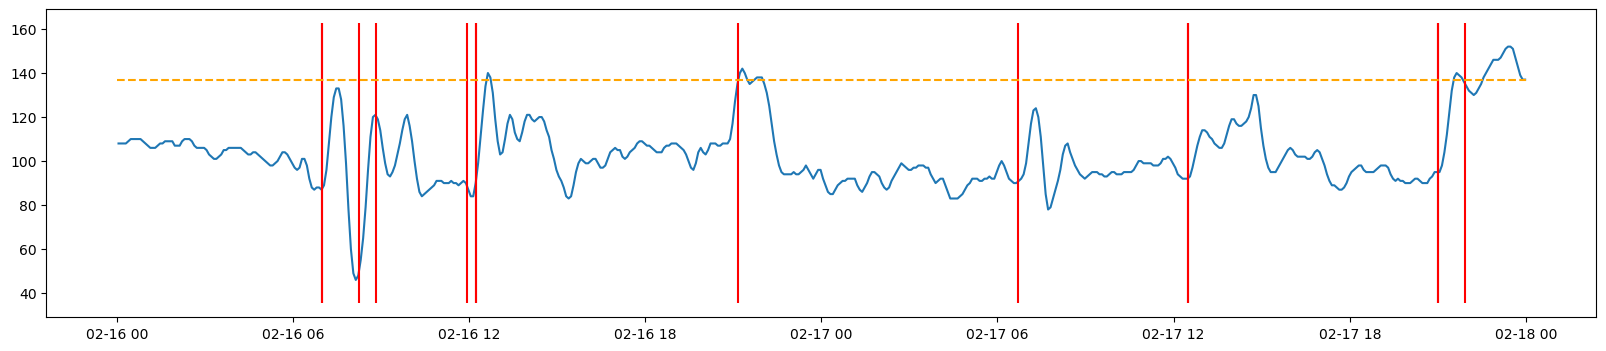

In [15]:
high_threshold = np.percentile(data[1].glu, 95)
print('High bloodsugar for Patient 1 set at', high_threshold, '(95th percentile)')

plot_series_with_food(data[1].glu, data[1].food, '2020-02-16', '2020-02-17')
plt.hlines(high_threshold, xmin=pd.Timestamp('2020-02-16'), xmax=pd.Timestamp('2020-02-17')+pd.Timedelta(days=1), colors="orange",linestyles="dashed")

plt.show()

High bloodsugar for Patient 2 set at 167.0 (95th percentile)


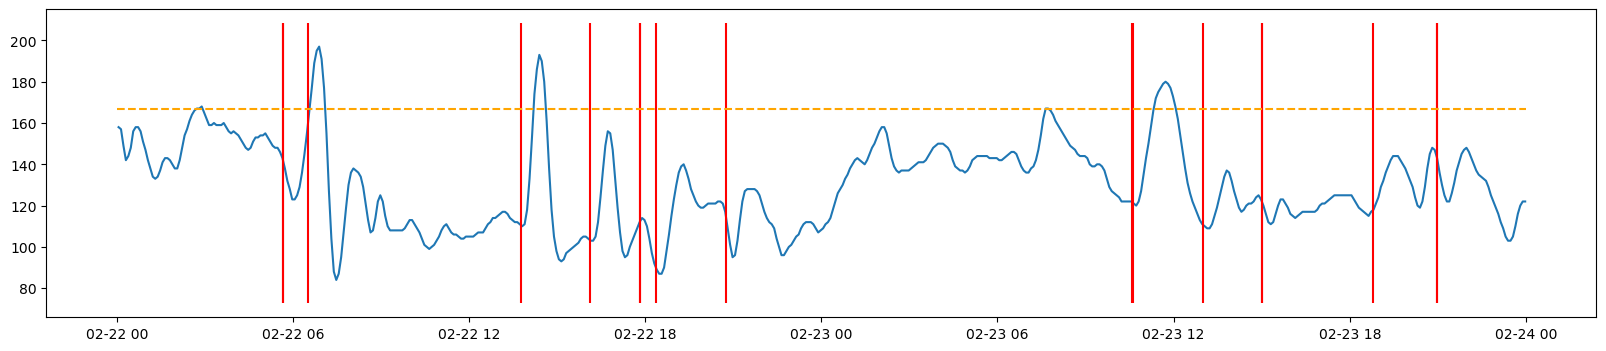

In [16]:
high_threshold = np.percentile(data[2].glu, 95)
print('High bloodsugar for Patient 2 set at', high_threshold, '(95th percentile)')

plot_series_with_food(data[2].glu, data[2].food, '2020-02-22', '2020-02-23')
plt.hlines(high_threshold, xmin=pd.Timestamp('2020-02-22'), xmax=pd.Timestamp('2020-02-23')+pd.Timedelta(days=1), colors="orange",linestyles="dashed")

plt.show()

Generally (but not always), high bloodsugars follow food intake of some sort. However, we miss a lot of glucose spikes this way: for example, if the glucose starts off low when eating, or on a downward trajectory, the resulting bloodsugar spike may not pass the high bloodsugar threshold.

### Version 2: Quantify bloodsugar spikes by difference data

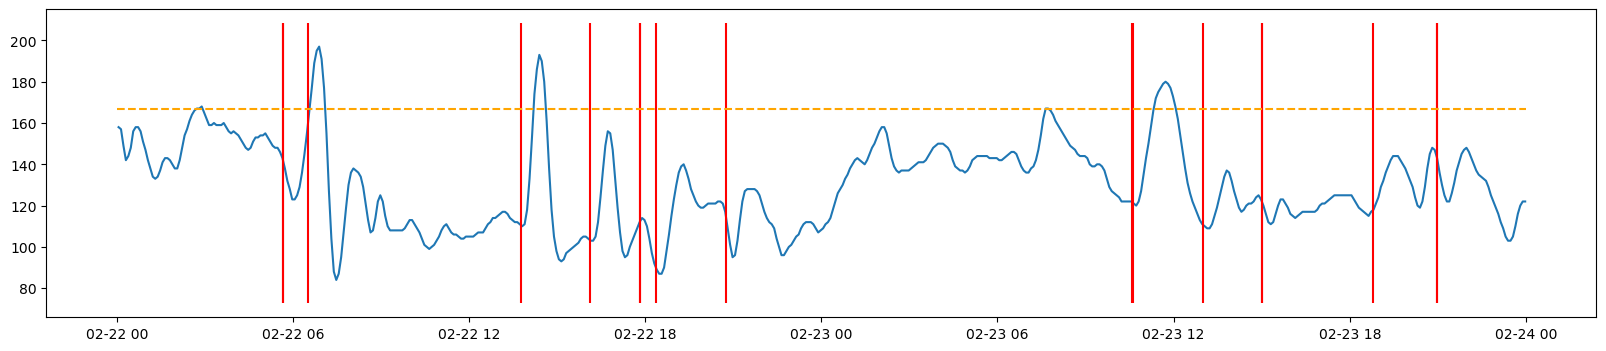

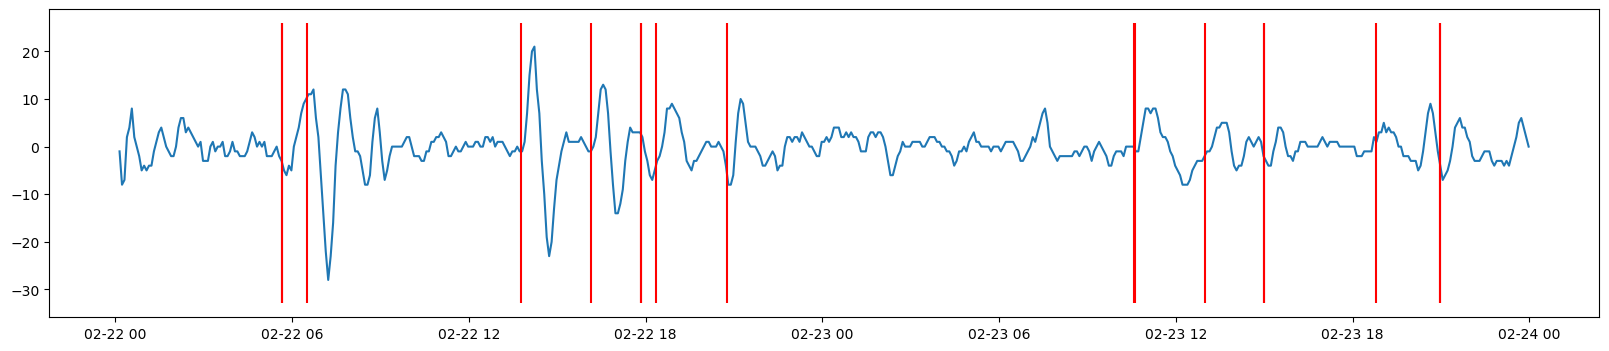

In [17]:
high_threshold = np.percentile(data[2].glu, 95)
plot_series_with_food(data[2].glu, data[2].food, '2020-02-22', '2020-02-23')
plt.hlines(high_threshold, xmin=pd.Timestamp('2020-02-22'), xmax=pd.Timestamp('2020-02-23')+pd.Timedelta(days=1), colors="orange",linestyles="dashed")

plt.show()

plot_series_with_diff(data[2].glu, data[2].food, '2020-02-22', '2020-02-23')
plt.show()

Now food intake shows up as a shock to the variability of the differences data. Note that many of the spikes that did not lead to a high bloodsugar nonetheless show up with comparable effect sizes in the differences graph.

The height of the bloodsugar spike is measured by the max glucose level post-meal minus the glucose level at time of a meal (another way to see this information is as the integral of the difference data from the time of the meal to the first zero of the difference data post-positive values).

## Exploring a bit more...

In [26]:
data[11].food

,time_end,logged_food,amount,unit,searched_food,calorie,total_carb,dietary_fiber,sugar,protein,total_fat
time_begin,,,,,,,,,,,
2020-04-06 10:00:00,2020-04-06 10:10:00,Banana,NaN,NaN,Banana,105.0,27.0,3.1,14.0,1.3,0.4
2020-04-06 11:40:00,2020-04-06 12:15:00,Cheese Steak,NaN,NaN,Cheese Steak,573.0,42.0,3.1,4.0,32.5,30.5
2020-04-06 11:40:00,2020-04-06 12:15:00,Tortilla,8.0,ounce,Tortilla,737.0,126.0,7.5,0.0,20.0,16.0
2020-04-06 11:40:00,2020-04-06 12:15:00,Rice,1.0,cup,Rice,205.0,45.0,0.6,0.1,4.3,0.4
2020-04-06 11:40:00,2020-04-06 12:15:00,Refried Beans,NaN,NaN,Refried Bean,214.0,32.0,8.6,1.3,12.0,4.8
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-15 17:00:00,2020-04-15 17:15:00,Peanuts,2.0,ounce,Peanuts,333.0,12.0,4.8,2.8,14.0,28.0
2020-04-15 20:15:00,2020-04-15 20:30:00,Banana Sandwich,1.0,NaN,Banana Sandwich,443.0,55.0,4.6,18.0,6.6,23.0
2020-04-15 20:15:00,2020-04-15 20:30:00,Cookies,3.0,NaN,Cookies,443.0,59.0,1.8,30.0,4.6,22.0


High bloodsugar for Patient 1 set at 166.0 (95th percentile)


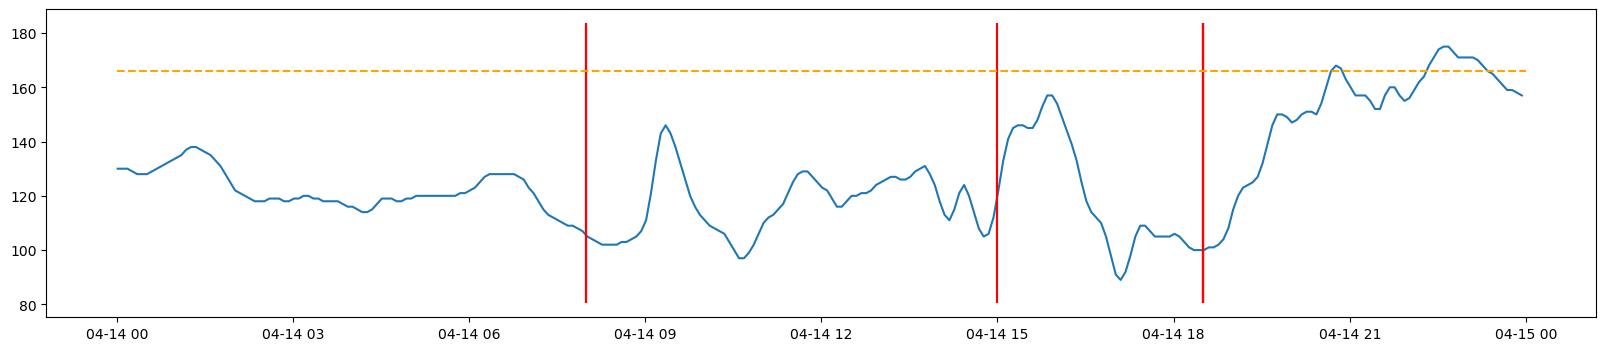

In [19]:
high_threshold = np.percentile(data[11].glu, 95)
print('High bloodsugar for Patient 1 set at', high_threshold, '(95th percentile)')

plot_series_with_food(data[11].glu, data[11].food, '2020-04-14', '2020-04-14')
plt.hlines(high_threshold, xmin=pd.Timestamp('2020-04-14'), xmax=pd.Timestamp('2020-04-14')+pd.Timedelta(days=1), colors="orange",linestyles="dashed")

plt.show()